In [1]:
import argparse
import logging

import numpy as np
import torch.autograd
import torch.cuda
import torch.nn as nn
import torch.optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import random

import copy
from datasets.maps_alt import MAPSDataset

#from cnn_ws.transformations.homography_augmentation import HomographyAugmentation
from cnn_ws.losses.cosine_loss import CosineLoss

from cnn_ws.models.myphocnet import PHOCNet
from cnn_ws.evaluation.retrieval import map_from_feature_matrix, map_from_query_test_feature_matrices
from torch.utils.data.dataloader import _DataLoaderIter as DataLoaderIter
from torch.utils.data.sampler import WeightedRandomSampler

from cnn_ws.utils.save_load import my_torch_save, my_torch_load

#import matplotlib.pyplot as plt

In [2]:
if not torch.cuda.is_available():
    logger.warning('Could not find CUDA environment, using CPU mode')
    gpu_id = None
else:
    gpu_id = [0]
#torch.cuda.get_device_name(gpu_id[0])
pass

In [3]:
model_ = torch.load('PHOCNet_allcases_new.pt')
cnn = model_.module#list(model_.named_parameters())
if gpu_id is not None:
        if len(gpu_id) > 1:
            cnn = nn.DataParallel(cnn, device_ids=gpu_id)
            cnn.cuda()
        else:
            cnn.cuda(gpu_id[0])
cnn.training = False

In [4]:
# find the file names
f = open('../splits/val_files.txt', 'rb')
A = f.readlines()
f.close()
A = [x.rstrip('\n') for x in A]

In [5]:
# load test images and words
images_before = np.load('../../../detection_outputs_ready_for_test/detected_regions/'+A[0]+'.npy')
words_before = np.load('../../../detection_outputs_ready_for_test/detected_labels/'+A[0]+'.npy')

images_after = np.load('../../../detection_outputs_ready_for_test/new_regions/'+A[0]+'.npy')
words_after = np.load('../../../detection_outputs_ready_for_test/new_labels/'+A[0]+'.npy')

In [6]:
images_before = np.transpose(images_before, (0,3,1,2))
images_after = np.transpose(images_after, (0,3,1,2))
print 'images_before shape',images_before.shape
print 'words_before shape',words_before.shape
print 'images_after shape',images_after.shape
print 'words_after shape',words_after.shape

images_before shape (536, 3, 135, 487)
words_before shape (536,)
images_after shape (469, 3, 135, 487)
words_after shape (469,)


In [7]:
# import matplotlib.pyplot as plt
# for i in range(len(images_after)):
#     if words_after[i] == 'Neosho':
#         print(i)
#         q = np.transpose(images_after[i],(1,2,0))
#         plt.imshow(q)
#         plt.show()

In [8]:
# convert image tnto embedding using the cnn model
def get_image_embeddings(images):
    outputs = []
    for i in tqdm(range(len(images))):
        word_img = images[i]
        word_img = 1 - word_img.astype(np.float32) / 255.0
        word_img = word_img.reshape((1,) + word_img.shape)
        word_img = torch.from_numpy(word_img).float()
        word_img = word_img.cuda(gpu_id[0])
        word_img = torch.autograd.Variable(word_img)
        output = torch.sigmoid(cnn(word_img))
        output = output.data.cpu().numpy().flatten()
        outputs.append(output)
    return outputs

outputs_before = get_image_embeddings(images_before)
outputs_after = get_image_embeddings(images_after)

100%|██████████| 469/469 [00:07<00:00, 62.73it/s]


In [9]:
# print(words_after[7])
# print(outputs_after[7])

In [10]:
# function to create word variations
# word_var is a dictionary that contains all variations as key and 0,1,-1 as value
# 0 denotes the root word, -1 denotes var = root_word[:-1], +1 denotes var = root_word[1:]
# root_word_var is a dict that stores original_word => all_variations
def create_word_variations(words):
    word_var = {}
    root_word_var = {}
    for w in words:
        if len(w) < 2:
            continue
        root_var_list = [w.lower(), w.upper(), w.capitalize()]
        var_set = set()
        for var in root_var_list:
            word_var[var] = 0
            word_var[var[1:]] = 1
            word_var[var[:-1]] = -1
            var_set.add(var)
            var_set.add(var[1:])
            var_set.add(var[:-1])
        root_word_var[w] = var_set
    return word_var, root_word_var

In [11]:
# compute the PHOC representation of the word itself
from cnn_ws.string_embeddings.phoc import build_phoc_descriptor
def get_word_phoc_representations(word_strings):
    unigrams = [chr(i) for i in range(ord('&'), ord('&')+1) + range(ord('A'), ord('Z')+1) + \
                    range(ord('a'), ord('z') + 1) + range(ord('0'), ord('9') + 1)]
    bigram_levels = None
    bigrams = None
    phoc_unigram_levels=(1, 2, 4, 8)
    word_var_dir, root_word_var = create_word_variations(word_strings)
    
    word_var_strings = word_var_dir.keys()
    embedding_var = build_phoc_descriptor(words=word_var_strings,
                                  phoc_unigrams=unigrams,
                                  bigram_levels=bigram_levels,
                                  phoc_bigrams=bigrams,
                                  unigram_levels=phoc_unigram_levels)
    
    print('embedding variations:', embedding_var.shape)
    return (embedding_var, word_var_strings, word_var_dir, root_word_var)

emb_info_before = get_word_phoc_representations(words_before)
emb_info_after = get_word_phoc_representations(words_after)
    

 33%|███▎      | 609/1871 [00:00<00:00, 6087.44it/s]

('embedding variations:', (1919, 945))


100%|██████████| 1871/1871 [00:00<00:00, 5953.21it/s]

('embedding variations:', (1871, 945))


In [12]:
# the new report matches method that handles variations
from scipy.spatial.distance import cdist, pdist, squareform
def report_matches_with_variations(outputs, matching, word_strings, emb_info, k, length):
    # expand emb_info tuple
    embedding_var, word_var_strings, word_var_dir, root_word_var = emb_info
    # length sorting stuff
    qualified_ids = [x for x in range(len(word_strings)) if len(word_strings[x]) > length]
    outputs = np.array(outputs)
    word_strings = np.array(word_strings)
    outputs = list(outputs[qualified_ids])
    word_strings = list(word_strings[qualified_ids])
    
    # same stuff for variations
    qualified_ids_vars = [x for x in range(len(word_var_strings)) if len(word_var_strings[x]) > (length-1)]
    embedding_var = np.array(embedding_var)
    word_var_strings = np.array(word_var_strings)
    embedding_var = list(embedding_var[qualified_ids_vars])
    word_var_strings = list(word_var_strings[qualified_ids_vars])
    
    # the real computation
    dist_mat = cdist(XA=outputs, XB=embedding_var, metric=matching)
    retrieval_indices = np.argsort(dist_mat, axis=1)
    q = retrieval_indices[:,:k]
    count = 0
    matched_words = []
    img_dir = []
    words_len = []
    actual_dist = []
    # get all matched words
    for i in range(len(q)):
        matched = []
        for j in q[i]:
            actual_dist.append(dist_mat[i][j])
            matched.append(word_var_strings[j])
            curr_len = len(word_var_strings[j])
            curr_dir = word_var_dir[word_var_strings[j]]
            words_len.append(curr_len + abs(curr_dir))
            img_dir.append(curr_dir)
        matched_words.append(matched)
    
    # calculate accuracies
    for i in range(len(word_strings)):
        #print word_strings[i]
        if word_strings[i] in matched_words[i]:
            count = count+1
        else:
            for w in matched_words[i]:
                if w in root_word_var[word_strings[i]]:
                    count = count+1
                    break

    #q = np.squeeze(np.array(q))
    #p = np.arange(len(q))
    #print count
    return (count, matched_words, qualified_ids, img_dir, words_len, outputs, word_strings, actual_dist)

In [13]:
# get the matches report
match_report_before = report_matches_with_variations(outputs_before,'cosine',words_before,emb_info_before,1, 2)
match_report_after = report_matches_with_variations(outputs_after,'cosine',words_after,emb_info_after,1, 2)

In [14]:
# word_before = match_report_before[6]
# dir_before = match_report_before[3]

# word_after = match_report_after[6]
# dir_after = match_report_after[3]

# for i in range(len(dir_before)):
#     if dir_before[i] == 0:
#         print(match_report_after[2][i],dir_before[i],dir_after[i],word_before[i], word_after[i], match_report_before[1][i], match_report_after[1][i])

In [15]:
# print "the accuracy before extension: "+str(match_report_before[0]/float(len(match_report_before[6])))
# print "the accuracy after extension: "+str(match_report_after[0]/float(len(match_report_after[6])))

In [16]:
# # original_qualified_ids, img_dir, matched_before, matched_after, ground_truth
# before_after_info = zip(match_report_before[2], match_report_before[3], match_report_before[1], match_report_after[1], match_report_before[6])
# before_after_info

In [17]:
# import csv
# with open('../../../before_after_extension_info/'+A[0]+'.csv', 'wb') as f:
#     writer = csv.writer(f)
#     for row in before_after_info:
#         writer.writerow(row)

************************************************************************
************************************************************************


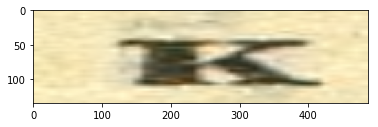

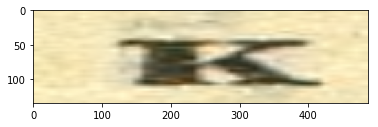

qualified id: 51,47
Matched before: a.
Matched after:Cas
Ground truth:OZARK
Distance before:0.16536728305287862
Distance after:0.40689021813214854
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


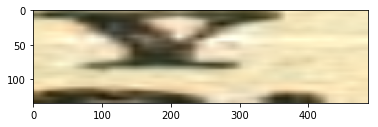

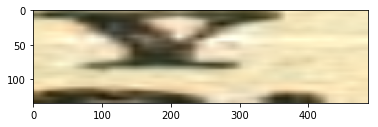

qualified id: 278,251
Matched before: R.
Matched after:Ra
Ground truth:CLAY
Distance before:0.8875272881325135
Distance after:0.9193023512361196
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


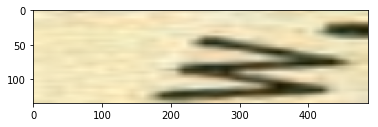

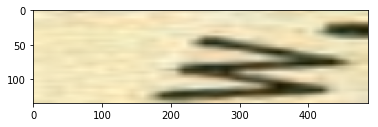

qualified id: 290,262
Matched before: a.
Matched after:Dad
Ground truth:Bentonville
Distance before:0.4100025564417663
Distance after:0.540087498248792
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


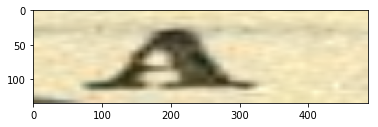

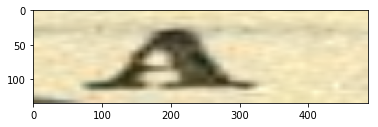

qualified id: 293,264
Matched before: A.
Matched after:it
Ground truth:DADE
Distance before:0.5416765801367385
Distance after:0.6091084303821847
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


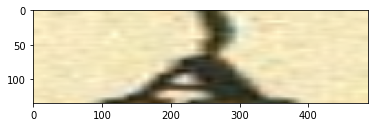

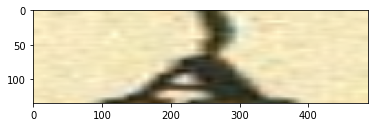

qualified id: 300,269
Matched before: k.
Matched after:ike
Ground truth:ADAIR
Distance before:0.5639661567142757
Distance after:0.7040351243664487
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


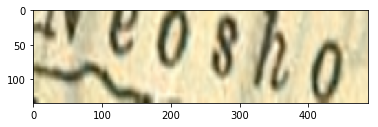

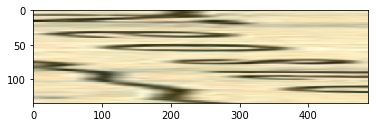

qualified id: 314,281
Matched before: stone
Matched after:Butle
Ground truth:Neosho
Distance before:0.3993516191816532
Distance after:0.4676484290140477
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


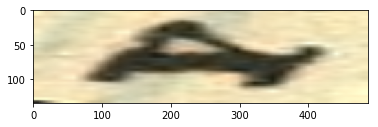

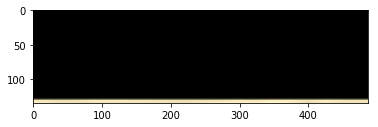

qualified id: 315,282
Matched before: M.
Matched after:allatin
Ground truth:RAY
Distance before:0.33464303479045665
Distance after:0.463719726145971
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


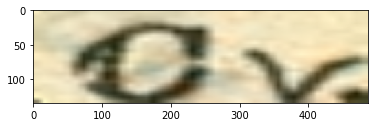

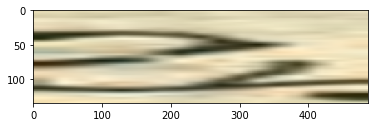

qualified id: 321,286
Matched before: a.
Matched after:ay
Ground truth:Cy.
Distance before:0.3003215061141242
Distance after:0.5691849283599681
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


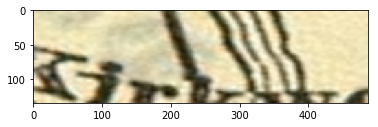

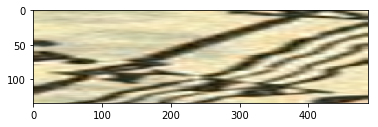

qualified id: 324,289
Matched before: line
Matched after:ity
Ground truth:Kirkwood
Distance before:0.3668338965381809
Distance after:0.4936842026937519
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


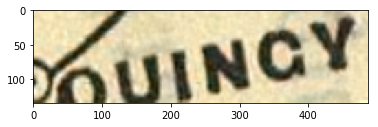

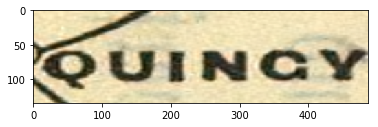

qualified id: 337,299
Matched before: linn
Matched after:Sulliva
Ground truth:QUINCY
Distance before:0.5620647421520975
Distance after:0.4753946272296937
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


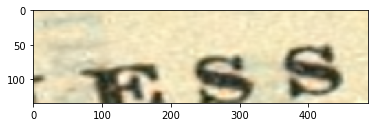

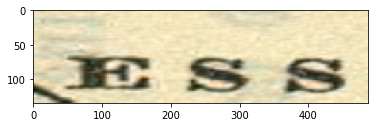

qualified id: 343,305
Matched before: cass
Matched after:EST
Ground truth:DAVIESS
Distance before:0.40378617404576955
Distance after:0.4482343420982623
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


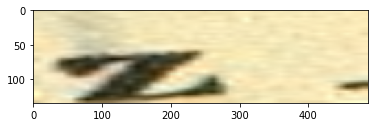

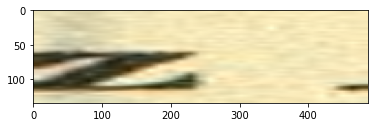

qualified id: 346,308
Matched before: o.
Matched after:OLK
Ground truth:OZARK
Distance before:0.2942130342908257
Distance after:0.7344956146440116
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


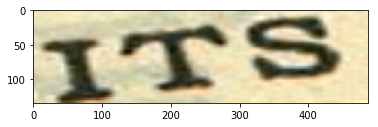

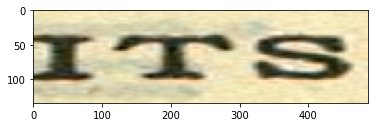

qualified id: 352,314
Matched before: O.
Matched after:miss
Ground truth:ITS
Distance before:0.9439810892360921
Distance after:0.3688601792954881
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


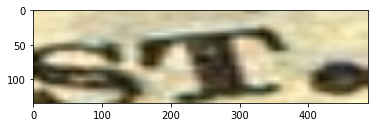

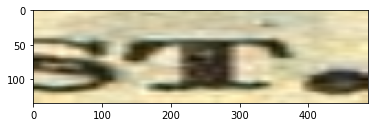

qualified id: 365,326
Matched before: paris
Matched after:SAGE
Ground truth:ST.
Distance before:0.47563333752668424
Distance after:0.38604748445298975
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


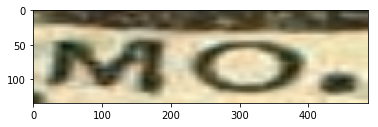

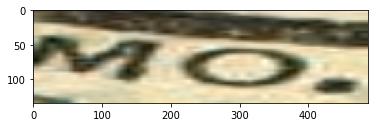

qualified id: 367,328
Matched before: Du
Matched after:ts
Ground truth:MO.
Distance before:0.5015953714321743
Distance after:0.5482527696679799
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


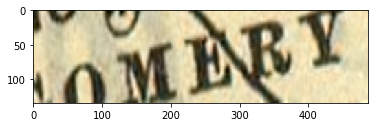

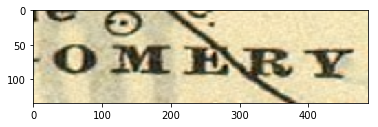

qualified id: 371,332
Matched before: TANEY
Matched after:O.
Ground truth:GOMERY
Distance before:0.34262268416983177
Distance after:0.3298897489136883
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


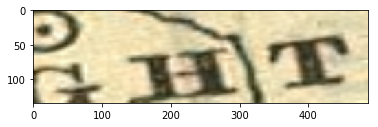

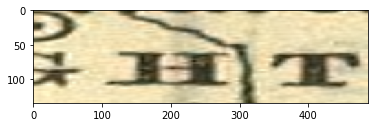

qualified id: 372,333
Matched before: St.
Matched after:umsey
Ground truth:Hartville
Distance before:0.3612803514472359
Distance after:0.461798321646948
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


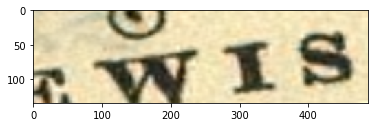

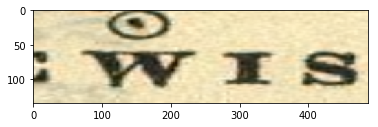

qualified id: 375,336
Matched before: N.
Matched after:OUIS
Ground truth:Monticello
Distance before:0.47986708912958287
Distance after:0.5015826183982139
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


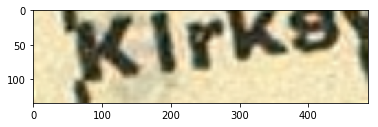

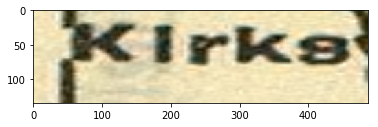

qualified id: 378,339
Matched before: Quincy
Matched after:Kirkwoo
Ground truth:Kirksville
Distance before:0.5173012358627128
Distance after:0.48263574680251176
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


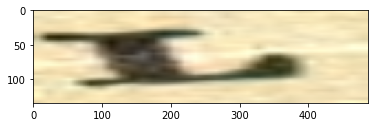

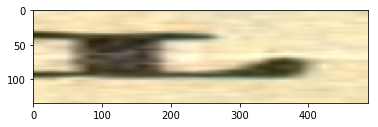

qualified id: 383,343
Matched before: K.
Matched after:EW
Ground truth:CLAY
Distance before:0.7982290327818755
Distance after:0.3365939949258627
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


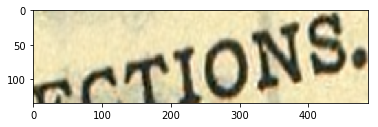

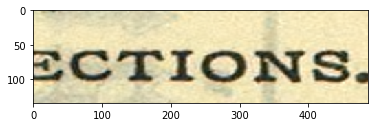

qualified id: 388,348
Matched before: STONE
Matched after:ETTIS
Ground truth:CONNECTIONS.
Distance before:0.3374553947662666
Distance after:0.4760167830883485
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


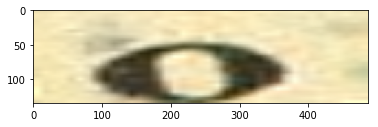

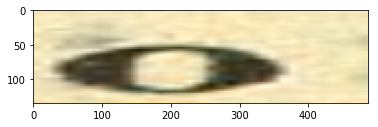

qualified id: 390,350
Matched before: r.
Matched after:cub
Ground truth:OREGON
Distance before:0.34548611453436484
Distance after:0.614249554520849
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


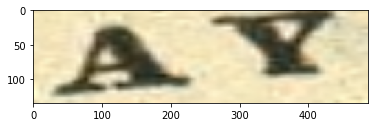

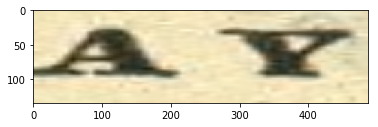

qualified id: 392,352
Matched before: A.
Matched after:ay
Ground truth:NODAWAY
Distance before:0.5572626497443955
Distance after:0.5778282604035201
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


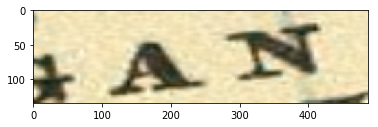

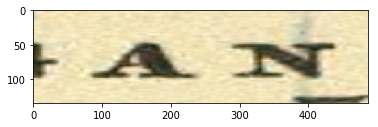

qualified id: 397,356
Matched before: TANEY
Matched after:ATES
Ground truth:MORGAN
Distance before:0.36444301677926505
Distance after:0.3455556081848935
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


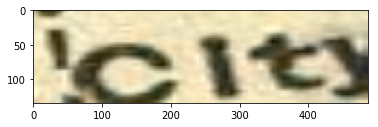

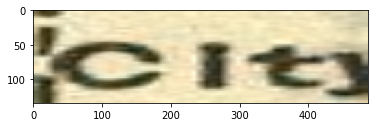

qualified id: 398,357
Matched before: Daviess
Matched after:it
Ground truth:City
Distance before:0.4951887213921412
Distance after:0.37342169928503655
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


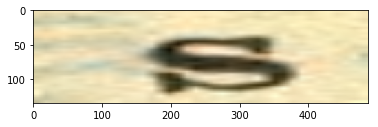

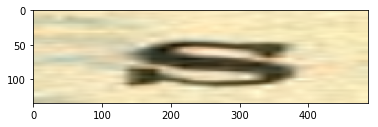

qualified id: 402,361
Matched before: m.
Matched after:ass
Ground truth:TEXAS
Distance before:0.23941792630484326
Distance after:0.6947793807624697
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


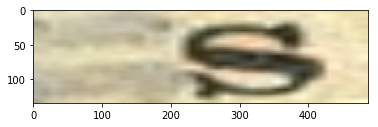

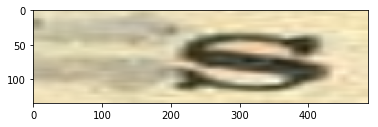

qualified id: 406,365
Matched before: miss.
Matched after:ts
Ground truth:CASS
Distance before:0.9365282564905124
Distance after:0.6162453985064098
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


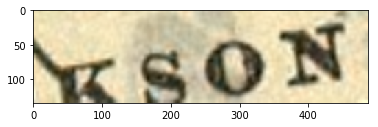

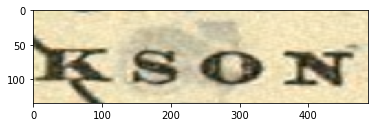

qualified id: 407,366
Matched before: TIPTON
Matched after:ST
Ground truth:KANSAS
Distance before:0.4019035600072647
Distance after:0.4350897407109564
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


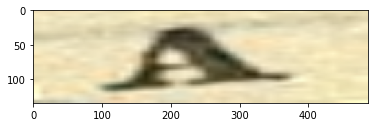

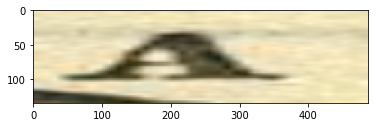

qualified id: 413,371
Matched before: MISS.
Matched after:CAS
Ground truth:DADE
Distance before:0.40455727302071187
Distance after:0.38830222944437986
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


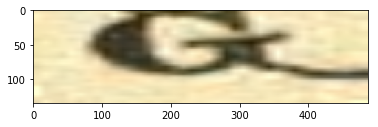

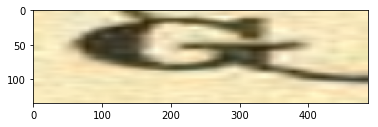

qualified id: 422,379
Matched before: r.
Matched after:it
Ground truth:DOUGLAS
Distance before:0.20558385265166346
Distance after:0.5473882041353371
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


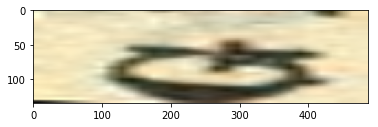

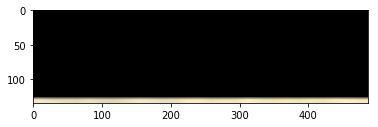

qualified id: 434,389
Matched before: james
Matched after:ERMITAGE
Ground truth:GRUNDY
Distance before:0.6302203418986436
Distance after:0.48164460516558427
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


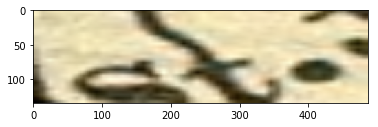

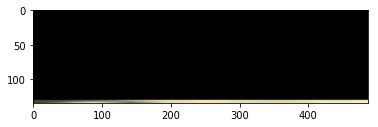

qualified id: 437,391
Matched before: Paris
Matched after:Eminenc
Ground truth:James
Distance before:0.4603036868180508
Distance after:0.4930471775150861
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


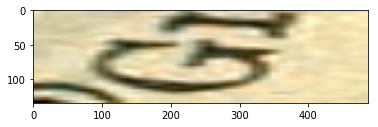

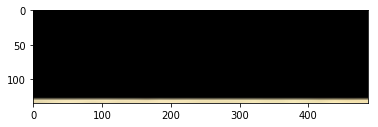

qualified id: 441,394
Matched before: miss.
Matched after:Hermitag
Ground truth:Grand
Distance before:0.45726583502565765
Distance after:0.4764137394270155
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


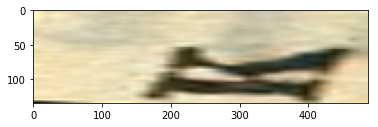

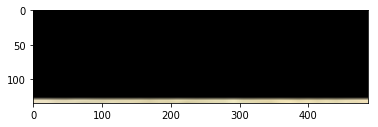

qualified id: 443,395
Matched before: Staat
Matched after:emi-
Ground truth:KNOX
Distance before:0.40222568142634085
Distance after:0.4984975070218587
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


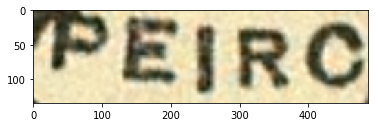

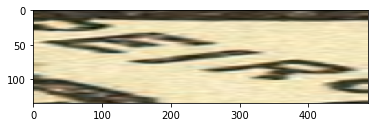

qualified id: 449,399
Matched before: FORT
Matched after:girar
Ground truth:PEIRCE
Distance before:0.47324482842268456
Distance after:0.6659605577295019
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


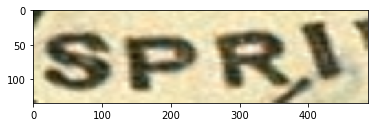

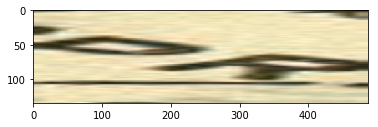

qualified id: 452,402
Matched before: perry
Matched after:NEB
Ground truth:SPRINGFIELD
Distance before:0.5238447282248915
Distance after:0.9467774502118088
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


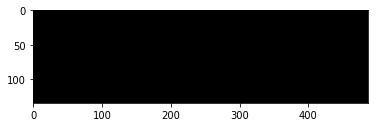

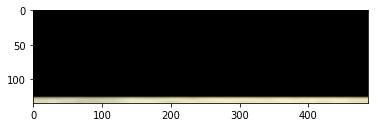

qualified id: 469,413
Matched before: M.
Matched after:ENT
Ground truth:MERCER
Distance before:0.5553336274108349
Distance after:0.37012353059963
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


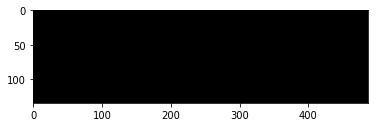

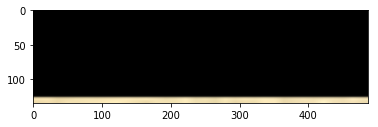

qualified id: 472,415
Matched before: M.
Matched after:DEN
Ground truth:MARION
Distance before:0.5553336274108349
Distance after:0.44045389853526506
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


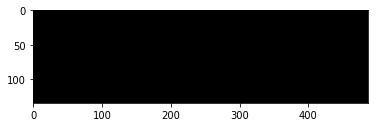

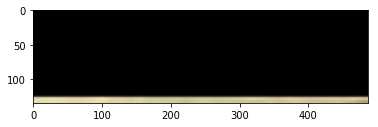

qualified id: 473,416
Matched before: M.
Matched after:EMI-
Ground truth:SHELBY
Distance before:0.5553336274108349
Distance after:0.4771358870779582
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


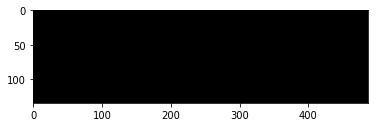

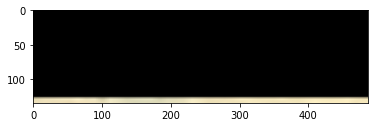

qualified id: 474,417
Matched before: M.
Matched after:ENT
Ground truth:NEWTON
Distance before:0.5553336274108349
Distance after:0.46120779585910776
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


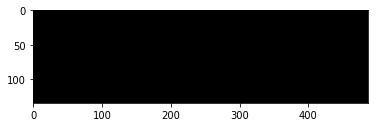

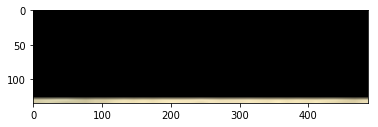

qualified id: 475,418
Matched before: M.
Matched after:ERA
Ground truth:Fort
Distance before:0.5553336274108349
Distance after:0.5500712575356692
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


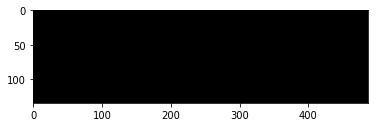

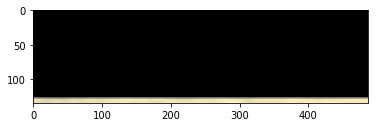

qualified id: 476,419
Matched before: M.
Matched after:ORT
Ground truth:MILLER
Distance before:0.5553336274108349
Distance after:0.4631156218022815
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


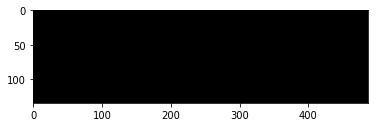

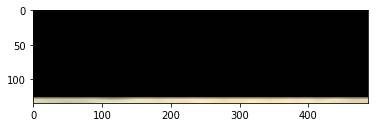

qualified id: 477,420
Matched before: M.
Matched after:ORT
Ground truth:NADE
Distance before:0.5553336274108349
Distance after:0.4970749880533336
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


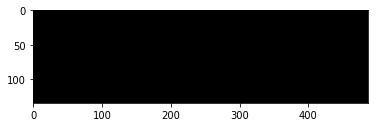

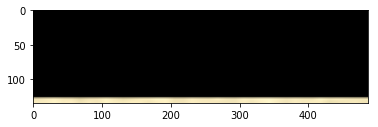

qualified id: 478,421
Matched before: M.
Matched after:ORT
Ground truth:CLEDE
Distance before:0.5553336274108349
Distance after:0.4769445090104396
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


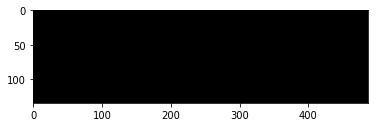

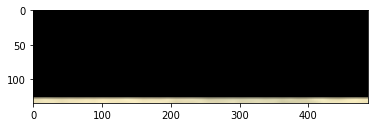

qualified id: 479,422
Matched before: M.
Matched after:ORT
Ground truth:MORGAN
Distance before:0.5553336274108349
Distance after:0.4529759209914077
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


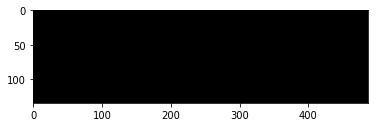

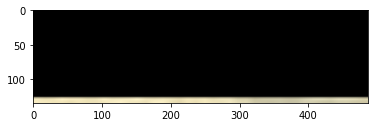

qualified id: 480,423
Matched before: M.
Matched after:ENT
Ground truth:STONE
Distance before:0.5553336274108349
Distance after:0.39711878422489744
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


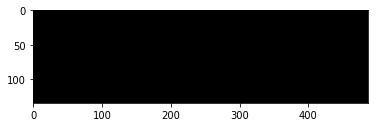

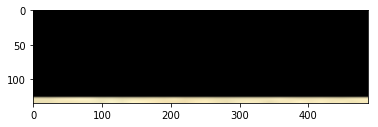

qualified id: 481,424
Matched before: M.
Matched after:ENT
Ground truth:WAYNE
Distance before:0.5553336274108349
Distance after:0.35041302237165295
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


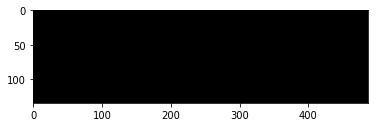

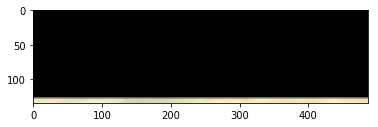

qualified id: 482,425
Matched before: M.
Matched after:ERMITAGE
Ground truth:ST.
Distance before:0.5553336274108349
Distance after:0.4902102826479091
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


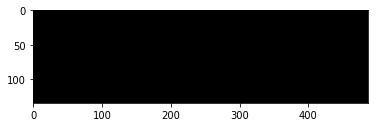

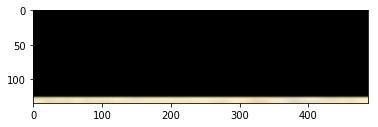

qualified id: 483,426
Matched before: M.
Matched after:DEN
Ground truth:GRUNDY
Distance before:0.5553336274108349
Distance after:0.4812630802068051
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


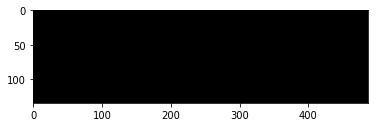

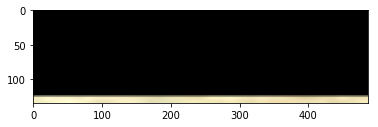

qualified id: 486,428
Matched before: M.
Matched after:Grund
Ground truth:DENT
Distance before:0.5553336274108349
Distance after:0.5940466003919159
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


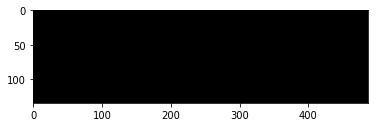

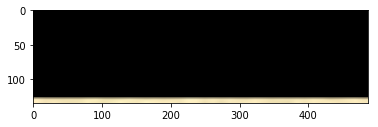

qualified id: 487,429
Matched before: M.
Matched after:ORT
Ground truth:CAMDEN
Distance before:0.5553336274108349
Distance after:0.47475224976129027
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


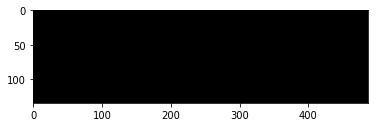

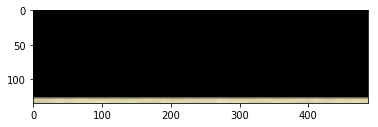

qualified id: 488,430
Matched before: M.
Matched after:ORT
Ground truth:Huntsville
Distance before:0.5553336274108349
Distance after:0.4827690427467545
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


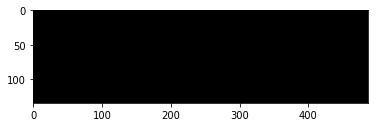

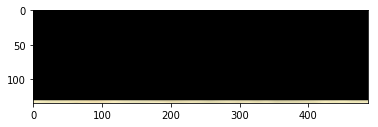

qualified id: 489,431
Matched before: M.
Matched after:Clai
Ground truth:LINN
Distance before:0.5553336274108349
Distance after:0.4555391489870867
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


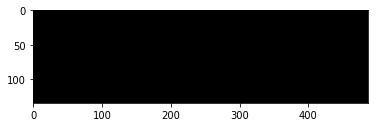

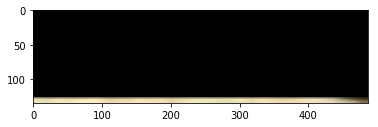

qualified id: 490,432
Matched before: M.
Matched after:ERA
Ground truth:MONITEAU
Distance before:0.5553336274108349
Distance after:0.3855068204869745
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


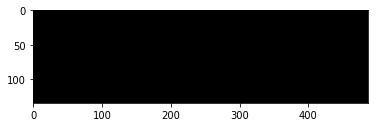

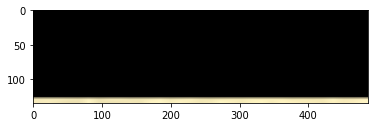

qualified id: 491,433
Matched before: M.
Matched after:ORT
Ground truth:STODDARD
Distance before:0.5553336274108349
Distance after:0.4694136668967396
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


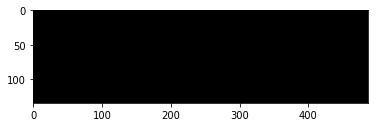

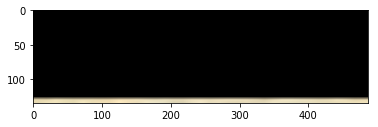

qualified id: 494,435
Matched before: M.
Matched after:ERA
Ground truth:Fayetteville
Distance before:0.5553336274108349
Distance after:0.47718213398261233
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


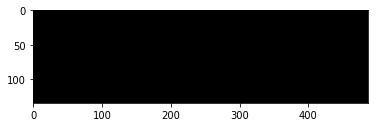

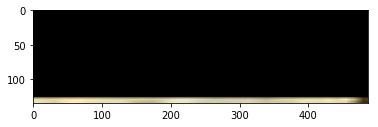

qualified id: 495,436
Matched before: M.
Matched after:EST
Ground truth:Kirksville
Distance before:0.5553336274108349
Distance after:0.43248621008121324
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


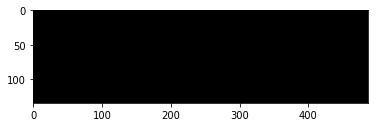

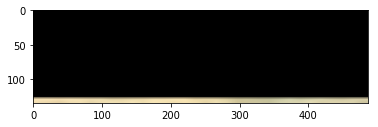

qualified id: 496,437
Matched before: M.
Matched after:ORT
Ground truth:MONRO
Distance before:0.5553336274108349
Distance after:0.4815571920308169
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


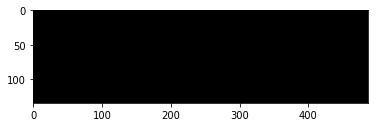

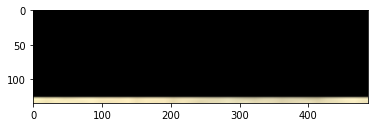

qualified id: 497,438
Matched before: M.
Matched after:ENT
Ground truth:Hermitage
Distance before:0.5553336274108349
Distance after:0.33676264538513
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


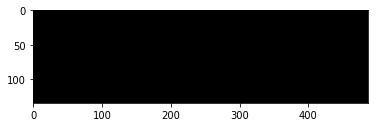

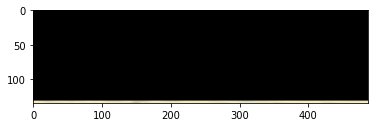

qualified id: 498,439
Matched before: M.
Matched after:Clai
Ground truth:ST.
Distance before:0.5553336274108349
Distance after:0.5081229924867642
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


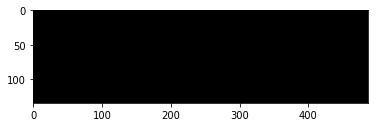

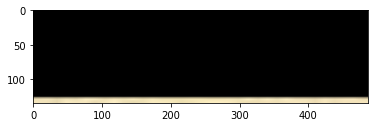

qualified id: 499,440
Matched before: M.
Matched after:ENT
Ground truth:JACKSON
Distance before:0.5553336274108349
Distance after:0.4206457891930685
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


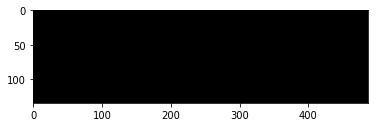

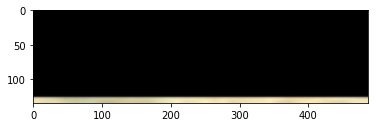

qualified id: 500,441
Matched before: M.
Matched after:ENT
Ground truth:GOMERY
Distance before:0.5553336274108349
Distance after:0.4705695098658438
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


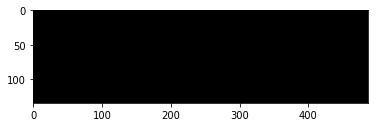

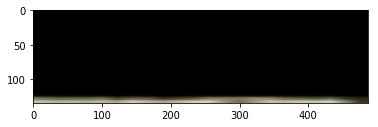

qualified id: 501,442
Matched before: M.
Matched after:marie
Ground truth:JO.
Distance before:0.5553336274108349
Distance after:0.3413926410927949
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


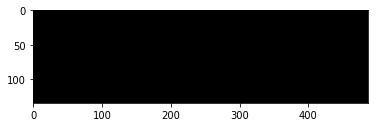

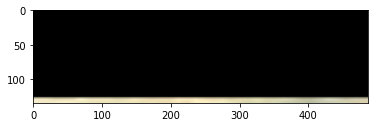

qualified id: 503,444
Matched before: M.
Matched after:ORT
Ground truth:PETTIS
Distance before:0.5553336274108349
Distance after:0.46288590287426123
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


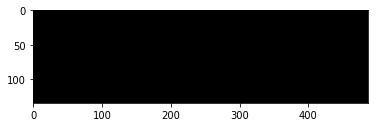

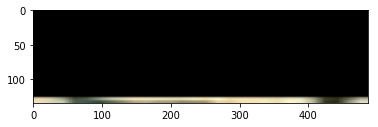

qualified id: 505,446
Matched before: M.
Matched after:hermitag
Ground truth:Greenfield
Distance before:0.5553336274108349
Distance after:0.4649549774135324
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


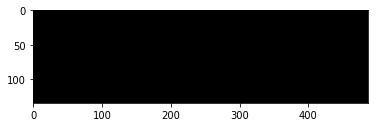

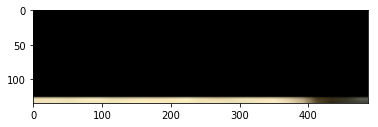

qualified id: 506,447
Matched before: M.
Matched after:HERMITAG
Ground truth:ST.
Distance before:0.5553336274108349
Distance after:0.4334649064635423
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


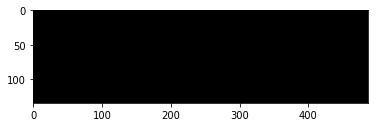

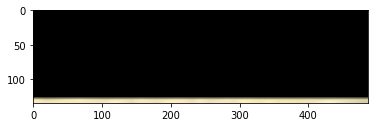

qualified id: 507,448
Matched before: M.
Matched after:ERA
Ground truth:RAILWAY,
Distance before:0.5553336274108349
Distance after:0.47380843440277765
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


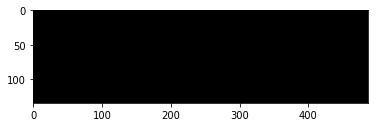

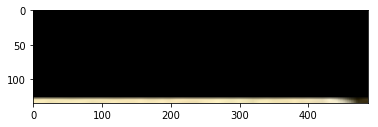

qualified id: 509,449
Matched before: M.
Matched after:ERA
Ground truth:Whitehall
Distance before:0.5553336274108349
Distance after:0.44902733079672597
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


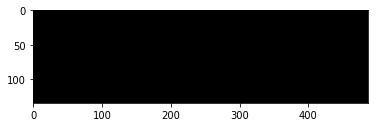

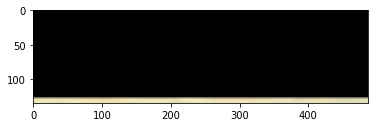

qualified id: 510,450
Matched before: M.
Matched after:ORT
Ground truth:NEW
Distance before:0.5553336274108349
Distance after:0.480690232482033
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


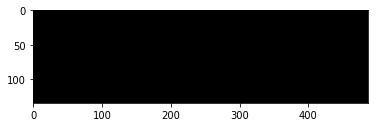

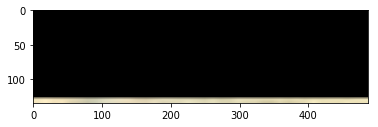

qualified id: 511,451
Matched before: M.
Matched after:ERMITAGE
Ground truth:SULLIVAN
Distance before:0.5553336274108349
Distance after:0.4966821662280674
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


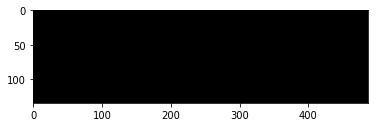

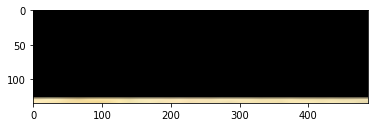

qualified id: 512,452
Matched before: M.
Matched after:ERMITAGE
Ground truth:MACON
Distance before:0.5553336274108349
Distance after:0.4975428578992952
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


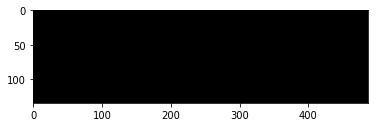

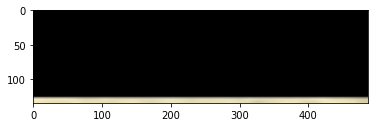

qualified id: 513,453
Matched before: M.
Matched after:ENT
Ground truth:no label attached
Distance before:0.5553336274108349
Distance after:0.44441955561375757
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


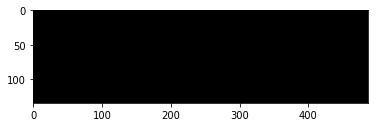

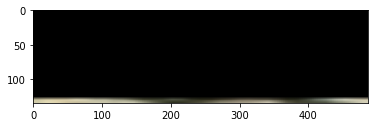

qualified id: 515,455
Matched before: M.
Matched after:ERA
Ground truth:POLK
Distance before:0.5553336274108349
Distance after:0.38552875306710577
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


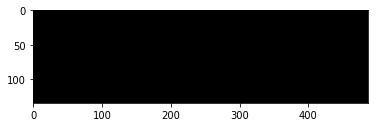

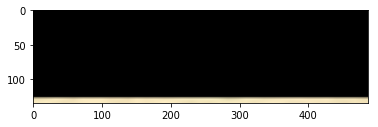

qualified id: 517,457
Matched before: M.
Matched after:ORT
Ground truth:PUTNAM
Distance before:0.5553336274108349
Distance after:0.45999880228932666
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


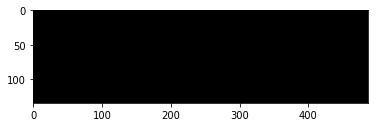

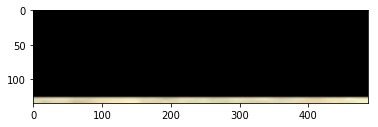

qualified id: 519,458
Matched before: M.
Matched after:ENT
Ground truth:Hill
Distance before:0.5553336274108349
Distance after:0.33550048074795835
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


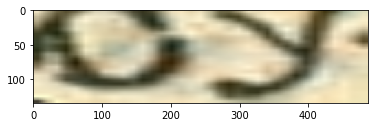

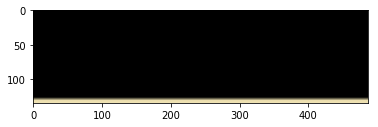

qualified id: 521,459
Matched before: Linn
Matched after:emi-
Ground truth:Cy.
Distance before:0.4286925468328018
Distance after:0.5057789572086104
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


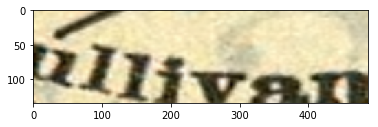

In [ ]:
import matplotlib.pyplot as plt
qualified_ids = match_report_before[2]
ground_truth = match_report_before[6]
for i in range(len(qualified_ids)):
    if match_report_before[3][i] == 0 \
    and match_report_after[3][i] != 0:
        print "************************************************************************"
        print "************************************************************************"
        q = np.transpose(images_before[qualified_ids[i]],(1,2,0))
        q1 = np.transpose(images_after[i],(1,2,0))
        plt.imshow(q)
        plt.show()
        plt.imshow(q1)
        plt.show()
        print "qualified id: "+str(match_report_before[2][i]) + "," + str(match_report_after[2][i])
        print "Matched before: "+str(match_report_before[1][i][0])
        print "Matched after:" + str(match_report_after[1][i][0])
        print "Ground truth:" + str(ground_truth[i])
        print "Distance before:" + str(match_report_before[7][i])
        print "Distance after:" + str(match_report_after[7][i])
        print "------------------------------------------------------------------------"
        print "------------------------------------------------------------------------"
        